Trong 2 phần trước ( [phần 1 :transfer learning trích xuất đặc trưng](https://github.com/mthang1801/deep-learning/blob/main/docs/04_transfer_learning_part_1_feature_extractor.ipynb) và [phần 2 : transfer learning được tinh chỉnh](https://github.com/mthang1801/deep-learning/blob/main/docs/04_transfer_learning_part_2_fine_tuning.ipynb)), chúng ta đã thấy được sức mạnh của những mô hình đã được train trước đó. Mặc dù những mô hình trước mà chúng ta làm là những mô hình sử dụng dữ liệu tương đối nhỏ (ít dữ liệu, ít class). Trong phần này, chúng ta sẽ sử dụng lượng dữ liệu lớn hơn. 

Trong Machine learning cũng như Deep learning, trước khi chính thức sử dụng một mô hình nào đó, chúng ta cần thử nghiệm khả năng học của nó. Một mô hình tốt là mô hình có khả năng học được trên cả lượng dữ liệu nhỏ đến lượng dữ liệu lớn. Do đó, khi xây dựng mô hình, chúng ta sẽ bắt đầu từ dữ liệu nhỏ, rồi sau đó dần dần mở rộng trên tập dữ liệu lớn hơn. 

Trong phần này, chúng ta sẽ mở rộng phạm vi dữ liệu từ việc sử dụng 10 class sang việc sử dụng tất cả các class trong tập dữ liệu Food101.

Mục tiêu của chúng ta là đánh bại kết quả của  [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) với 10% dữ liệu.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-ml-serial-experimentation.png)
*Quy trình mô hình làm việc với dữ liệu:  Bắt đầu với quy mô nhỏ, làm cho một mô hình hoạt động, xem thử nghiệm có hoạt động hay không, sau đó dần dần mở rộng quy mô lớn hơn và càng lớn hơn(chúng ta sẽ xem xét việc mở rộng phạm vi dữ liệu trong suốt sổ ghi chép này)*

Nội dụng trong phần này : 

1. Download và chuẩn bị 10% dữ liệu cho 101 class trong Food101
2. Xây dựng mô hình Transfer learning trích xuất đặc trưng 
3. Tinh chỉnh mô hình trích xuất đặc trưng
4. Lưu và Load mô hình
5. Đánh giá hiệu suất mô hình
  - Dự đoán hình ảnh lấy từ dữ liệu test
  - Sử dụng các phương pháp đánh giá từ sklearn
  - Sử dụng pandas để  Tìm top các dự đoán sai trong mô hình.

## 1. Download và chuẩn bị 10% dữ liệu cho 101 class trong Food101

Trong tập dữ liệu gốc của Food101, có 1000 hình ảnh cho mỗi class (750 hình ảnh để `train` và 250 hình ảnh để `test`), tổng cộng 101.000 hình ảnh.

Trước khi  toàn bộ hình ảnh của tập dữ liệu `train` trên 101 class, chúng ta sẽ thử nghiệm với 10% dữ liệu `train` của nó.

In [1]:
!wget https://www.dropbox.com/s/8pakapzwodimtvw/all_food_classes_10_percent.zip

--2021-09-13 09:52:39--  https://www.dropbox.com/s/8pakapzwodimtvw/all_food_classes_10_percent.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8pakapzwodimtvw/all_food_classes_10_percent.zip [following]
--2021-09-13 09:52:39--  https://www.dropbox.com/s/raw/8pakapzwodimtvw/all_food_classes_10_percent.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd598461b8ebfa643d0180895bc.dl.dropboxusercontent.com/cd/0/inline/BWGheHVkovaBJMw16kQwtv1eQS2eiicF-5CwZ2PandtGy8XfyV7h9k8Nj4GfLPIjOD_cS2V4cQhlG0b0uSmgSD7W3EJYw9Wt3Zkq_1WILtZEWqr_eD-s7qYDsBR6KmEeg0g7Xyst6eXJ9foO-GlnG-Og/file# [following]
--2021-09-13 09:52:39--  https://ucd598461b8ebfa643d0180895bc.dl.dropboxusercontent.com/cd/0/inline/BWGheHVkovaBJMw16kQwtv1eQS2eiicF-

Như thường lệ, trước khi xây dựng mô hình, chúng ta cần phải hiểu dữ liệu hiện tại là gì, cấu trúc của dữ liệu gồm những gì, nó đã được chia thành 2 phần `train` và `test` hay chưa... Do đó, chúng ta sẽ dạo quanh tập dữ liệu vừa mới tải xuống. Để toàn bộ code trong notebook được gọn gàng, chúng ta có thể viết những hàm có thể tái sử dụng nhiều lần trong file khác rồi sau đó import các hàm trong file đó. Với bài viết này sẽ import utility function này trên cloud. 

In [2]:
!wget https://www.dropbox.com/s/v4sla7jvi9cltg8/utility_functions.py

--2021-09-13 09:53:00--  https://www.dropbox.com/s/v4sla7jvi9cltg8/utility_functions.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/v4sla7jvi9cltg8/utility_functions.py [following]
--2021-09-13 09:53:00--  https://www.dropbox.com/s/raw/v4sla7jvi9cltg8/utility_functions.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdb5b64ab5179a12b8931919628.dl.dropboxusercontent.com/cd/0/inline/BWEkgj-OjwZ7cu4jEyb1zeg7EARwjWvfGklXjjJF1dqvH8dnzqWpmO4-k561_eDQL93A0apsiDaWNMmGQKknaUGz_QHOmwZ9jW5PDVfcivjRMQuYWgFGEHi8ASpwN5DS93qovlaubtO2ep3bPJAcrnVt/file# [following]
--2021-09-13 09:53:00--  https://ucdb5b64ab5179a12b8931919628.dl.dropboxusercontent.com/cd/0/inline/BWEkgj-OjwZ7cu4jEyb1zeg7EARwjWvfGklXjjJF1dqvH8dnzqWpmO4-k561_eDQL9

In [3]:
from utility_functions import walk_through_directory, unzip_file, plot_loss_curves,create_tensorboard_callback, compare_history , plot_confusion_matrix

Giải nén tập tin "all_food_classes_10_percent.zip"

In [4]:
unzip_file("/content/all_food_classes_10_percent.zip")

Unzipped file


In [5]:
walk_through_directory("/content/all_food_classes_10_percent")

Có 2 thư mục và 0 tập tin trong thư mục /content/all_food_classes_10_percent
Có 101 thư mục và 0 tập tin trong thư mục /content/all_food_classes_10_percent/train
Có 0 thư mục và 75 tập tin trong thư mục /content/all_food_classes_10_percent/train/breakfast_burrito
Có 0 thư mục và 75 tập tin trong thư mục /content/all_food_classes_10_percent/train/beef_tartare
Có 0 thư mục và 75 tập tin trong thư mục /content/all_food_classes_10_percent/train/fried_calamari
Có 0 thư mục và 75 tập tin trong thư mục /content/all_food_classes_10_percent/train/spring_rolls
Có 0 thư mục và 75 tập tin trong thư mục /content/all_food_classes_10_percent/train/steak
Có 0 thư mục và 75 tập tin trong thư mục /content/all_food_classes_10_percent/train/onion_rings
Có 0 thư mục và 75 tập tin trong thư mục /content/all_food_classes_10_percent/train/samosa
Có 0 thư mục và 75 tập tin trong thư mục /content/all_food_classes_10_percent/train/hot_dog
Có 0 thư mục và 75 tập tin trong thư mục /content/all_food_classes_10_perc

Sử dụng hàm [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) để chuyển dữ liệu hình ảnh và label của nó vào [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), một kiểu dữ liệu TensorFlow cho phép chúng ta chuyển thư mục của nó vào mô hình.

Đối với tập dữ liệu test, chúng ta sẽ đặt `shuffle = False` để những dữ liệu này được đưa vào đúng theo trình tự, đồng thời giúp cho chúng ta có thể  dễ dàng đánh giá và quan sát đúng vị trí hình hiện tại trong tập dữ liệu đó.


In [6]:
import tensorflow as tf

In [7]:
train_dir = "all_food_classes_10_percent/train"
test_dir = "all_food_classes_10_percent/test"

In [8]:
IMAGE_SHAPE=(224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMAGE_SHAPE,
    shuffle=True,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMAGE_SHAPE,
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Với việc sử dụng `tf.data.Dataset` API, chúng ta có thể lấy được tên của các class với thuộc tính `class_names`

In [9]:
class_names = train_data_10_percent.class_names
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

Dữ liệu của chúng ta đã được import như kỳ vọng, 75 hình ảnh / class, có 101 class nên 75 * 101 = 7575 hình ảnh để train. Và 250 hình ảnh test / class, nên có 250 * 101 = 25250 class.

Dữ liệu hình ảnh về 101 food của chúng ta đã được import vào TensorFlow, tiếp theo sẽ là lập mô hình.

## 2. Xây dựng mô hình Transfer learning trích xuất đặc trưng

Để thử nghiệm nhanh chóng với lượng dữ liệu hiện tại, chúng ta sẽ bắt đầu bằng mô hình transfer learning trích xuất đặc trưng, mô hình này chúng ta sẽ sử dụng toàn bộ các đặc trưng mà mô hình đã được train trước đó trong 5 epoch đầu tiên. Sau đó, ta sẽ cải thiện mô hình bằng cách tinh chỉnh một vài layer và train thêm 5 epoch nữa. 

Cụ thể hơn, mục tiêu của chúng ta sẽ là xây dựng mô hình có thể vượt qua đường cơ sở tại [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)(độ chính xác 50,76% trên 101 lớp) với 10% dữ liệu train. Và các bước thiết lập mô hình như sau : 
+ Tạo hàm `ModelCheckPoint Callback` để lưu quá trình train của mô hình trong 5 epoch đầu tiên. Điều này giúp chúng ta sau này có thể train mô hình tiếp tục mà không cần phải train lại từ đầu. 
+ Tạo input layer truyền vào kích thước hình ảnh
+ Làm dữ liệu được tăng tính đa dạng (data augmentation) được tích hợp thành 1 layer trong mô hình. 
+ Sử dụng mô hình transfer learning làm mô hình cơ sở với kiến trúc [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) 
+ Tạo 1 output layer là `Dense` layer với unit neuron là 101 (có thể hiểu layer này sẽ tính toán xác suất có thể xảy ra với số class tương ứng) và sử dụng hàm activation là `softmax` (đại diên cho mô hình phân loại)+ Tạo mô hình, đưa các inputs, và output vào mô hình
+ Biên dịch mô hình (compile) bao gồm : 
  + hàm loss : `categorical_crossentropy` 
  + trình tối ưu cho mô hình : `Adam` 
  + Không gian đo khả năng học của mô hình `accuracy` 
+ Fit mô hình với 5 epoch với `train_data` là dữ liệu được dùng để train, `test_data` là dữ liệu để kiểm định sau mỗi khi quá trình `train` kết thúc.

Để bắt đầu, chúng ta sẽ tạo hàm để gọi `ModelCheckPoint` callback : 

In [10]:
import os 

def create_checkpoint_model_callback(dir_name, experiment_name) : 
  checkpoint_path = os.path.join(dir_name, experiment_name + ".ckpt")
  checkpoint_model_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                           monitor="val_loss",
                                                           verbose=1,
                                                           save_best_only=False, 
                                                           save_weights_only=True)
  print(f"Đã lưu checkpoint model callback vào {checkpoint_path}")
  return checkpoint_model_cb

In [11]:
from tensorflow.keras import Sequential, Model, layers
from tensorflow.keras.layers.experimental import preprocessing

Chúng ta sẽ tạo sẵn mộ mô hình giúp biến dữ liệu trở nên đa dạng (data augmentation) và sau đó chèn mô hình này như một layer vào mô hình Functional API.

`Functional API` là lúc chúng ta kết hợp các layer với mô hình transfer learning trích xuất đặc trưng (trong trường hợp này là `EfficientB0` được sử dụng như mô hình cơ sở.

In [12]:
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), 
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomRotation(0.25),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1./255) # giữ lại nếu là mô hình như ResNet50V2, không sử dụng cho EfficientNet
])

Mô hình cơ sở của chúng ta sẽ giữ nguyên các trích xuất đặc trưng, sử dụng `include_top=False` để thay đổi số class output mặc định của mô hình này là 1000 thành số class phù hợp với dữ liệu của chúng ta (101 class). Lưu ý, `GlobalAveragePooling2D()` giúp cô đọng các output của mô hình cơ sở thành hình dạng phù hợp với hình dạng có thể dùng cho output layer được định nghĩa bởi `Dense` layer tiếp nối.

In [13]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
# Set trainable là  False để các layer trong base_model được giữ nguyên các trọng số  (weights) và bias
base_model.trainable=False

16719872/16705208 [==============================] - 0s 0us/step


In [14]:
# Định nghĩa inputs cho mô hình (hình dạng của dữ liệu)
inputs = layers.Input(shape=IMAGE_SHAPE+(3,), name="inputs_layer")
# Định nghĩa layer làm dữ liệu bị 'biến dạng' 
inputs_augmetation = data_augmentation(inputs)
# Chèn layer trên vào base_model
x = base_model(inputs_augmetation, training=False)
# Sử dụng GlobalAveragePooling2D để gộp các output của base_model trên 
x = layers.GlobalAveragePooling2D()(x)
# Tạo output bằng Dense layer với units neuron chính là số class của dữ liệu, và activation là softmax
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_0 = Model(inputs, outputs, name="model_0")

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-efficientnetb0-feature-extractor-with-dense-layer-on-top.png)
*Một hình ảnh với đầy màu sắc của mô hình mà chúng ta đã tạo với: kích thước 224x224 làm input, tiếp nối là một layer data augmentation làm dữ liệu được biến dạng, mô hình EfficientNetB0 là vai trò chính để train mô hình, layer `GlobalAveragePooling2D` và `Dense` với 10 unit neurons dưới dạng output.*

Tổng quan mô hình

In [15]:
model_0.summary()

Model: "model_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_layer (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


Mô hình Functional API chúng ta có 5 layer, nhưng trong mỗi layer lại chứa những layer khác để tạo nên nó. VD, `efficientnetb0 (Functional)` có 238 layer chứa trong nó. 

Tiếp theo chúng ta sẽ biên dịch mô hình và bắt đầu train mô hình bằng phương thức `fit` 

In [16]:
# Tạo số epoch để thực hiện transfer learning trích xuất đặc trưng
initial_epoch=5 

# Biên dịch mô hình (compile): 
model_0.compile(
    loss="categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"]
)

# Fit mô hình
model_0_feature_extraction_history = model_0.fit(
    train_data_10_percent,
    steps_per_epoch=len(train_data_10_percent), 
    epochs=initial_epoch,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[
               create_tensorboard_callback("transfer_learning", "efficientB0_extract_feature_101_class_10_percent_data"),
               create_checkpoint_model_callback("model_checkpoints", "model_0_feature_extraction")
    ]
)



Đã lưu tensorboard vào transfer_learning/efficientB0_extract_feature_101_class_10_percent_data/13092021-095346
Đã lưu checkpoint model callback vào model_checkpoints/model_0_feature_extraction.ckpt
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


237/237 [==============================] - 164s 552ms/step - loss: 3.5476 - accuracy: 0.2330 - val_loss: 2.6884 - val_accuracy: 0.3969

Epoch 00001: saving model to model_checkpoints/model_0_feature_extraction.ckpt
Epoch 2/5
237/237 [==============================] - 104s 437ms/step - loss: 2.4958 - accuracy: 0.4273 - val_loss: 2.2587 - val_accuracy: 0.4603

Epoch 00002: saving model to model_checkpoints/model_0_feature_extraction.ckpt
Epoch 3/5
237/237 [==============================] - 113s 475ms/step - loss: 2.1429 - accuracy: 0.4944 - val_loss: 2.0893 - val_accuracy: 0.4826

Epoch 00003: saving model to model_checkpoints/model_0_feature_extraction.ckpt
Epoch 4/5
237/237 [==============================] - 93s 389ms/step - loss: 1.9279 - accuracy: 0.5328 - val_loss: 1.9487 - val_accuracy: 0.5070

Epoch 00004: saving model to model_checkpoints/model_0_feature_extraction.ckpt
Epoch 5/5
237/237 [==============================] - 87s 367ms/step - loss: 1.7816 - accuracy: 0.5706 - val_los

In [17]:
results_model_0_feature_extraction = model_0.evaluate(test_data)
results_model_0_feature_extraction

790/790 [==============================] - 102s 128ms/step - loss: 1.7848 - accuracy: 0.5410


[1.7848315238952637, 0.5409504771232605]

`accuracy` của mô hình đạt ~53% vượt qua độ chính xác cơ sở trong [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) chỉ với 10% dữ liệu. 😂

learning curves của mô hình: 



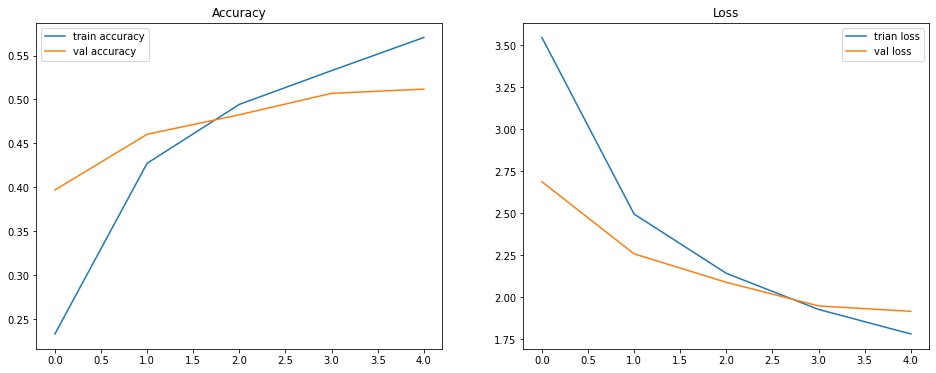

In [18]:
plot_loss_curves(model_0_feature_extraction_history)

> 🤔 Tại sao chúng ta lại vẽ đường learning curves? Về cơ bản, chúng ta sẽ đánh giá quá trình học của mô hình và quá trình tự đánh giá lại sau mỗi lần nó học xong, để xác định xác liệu mô hình có bị `overfitting` hay `underfitting` hay không. 

## 3. Tinh chỉnh mô hình trích xuất đặc trưng

Mô hình trích xuất đặc trưng đã thực hiện khá tốt với 101 class. Nhưng để mô hình có thể học tốt hơn, chúng ta sẽ mở một số layer trong `base_model` được phép train lại trên dữ liệu của chúng ta. 

Nhờ `model_0` vừa rồi chúng ta có sử dụng `ModelCheckpoint` callback để lưu lại toàn bộ các trọng số  của mô hình với 5 epoch, nên shúng ta sẽ thực hiện tinh chỉnh mô hình với 5 epoch tiếp theo, nếu mô hình train tốt, chúng ta sẽ giữ lại mô hình mới, còn nếu không tốt chúng ta sẽ load lại 5 epoch của  mô hình trích xuất đặc trưng như phần trên mà không cần phải train lại từ đầu. 

Để tinh chỉnh mô hình `base_model`, chúng ta sẽ set lại trainable của `base_model` thành `True`. Khi dữ liệu càng lớn, số layer cho phép train lai càng nhiều sẽ càng tốt, nhưng chúng ta chỉ sử dụng 10% dữ liệu cho mọi class, nên chúng ta sẽ chỉ cho phép một vài layer trên cùng được train lại, phần lại vẫn giữ nguyên. 

Cụ thể, sử dụng 5% layer trên cùng được phép train lại, 90% vẫn giữ nguyên. 

Đầu tiên chúng ta sẽ xác định 5% layer cuối bắt đầu từ đâu

In [19]:
get_total_base_model_layers = len(base_model.layers)
last_ten_percent_of_total_number_layers = int(0.95 * get_total_base_model_layers )
last_ten_percent_of_total_number_layers


225

Vậy 5% layer cuối cùng bắt đầu từ layer thứ **225**. 

+ Set `base_model.trainable = False` 
+ Tạo vòng lặp để  cho phép layer thứ 213 trở về sau được train

In [20]:
base_model.trainable = False 

for layer in base_model.layers[last_ten_percent_of_total_number_layers:] : 
  layer.trainable = True

Kiểm tra lại xem trong `base_model` đã cho phép train một số layer trên cùng hay chưa. 

In [21]:
for layer_index, layer in enumerate(base_model.layers) : 
  if layer.trainable : 
    print(layer_index, layer.name)

225 block7a_bn
226 block7a_activation
227 block7a_se_squeeze
228 block7a_se_reshape
229 block7a_se_reduce
230 block7a_se_expand
231 block7a_se_excite
232 block7a_project_conv
233 block7a_project_bn
234 top_conv
235 top_bn
236 top_activation


Bởi vì đang tinh chỉnh, nên chúng ta sẽ sử dụng learning_rate thấp hơn 10 lần để đảm bảo các quá trình cập nhật lại các trong số đã được train trước đó không quá lớn. 

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-lowering-the-learning-rate.png)
*Khi tinh chỉnh và mở các layer của mô hình được train đã được train trước đó, thông thường bạn nên giảm learning_rate mà bạn đã sử dụng cho mô hình trích xuất đặc trưng của mình. Bằng bao nhiêu? Learning rate nên thấp hơn 10 lần thường sẽ là lựa chọn tốt để bắt đầu.*

In [22]:
model_0.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # mặc định là 0.001, ta sẽ giảm 10 lần giá trị mặc định
    metrics=["accuracy"]
)

Mô hình `model_0` đã được compile lại, chúng ta sẽ thiếp lập cho mô hình này train tiếp tục thêm 5 epoch nữa.

In [23]:
fine_tune_epoch = initial_epoch + 5 

model_0_fine_tune_history = model_0.fit(
    train_data_10_percent,
    steps_per_epoch = len(train_data_10_percent),
    epochs=fine_tune_epoch, 
    initial_epoch=model_0_feature_extraction_history.epoch[-1],
    validation_data=test_data, 
    validation_steps=int(0.25 * len(test_data)), 
    callbacks=[
               create_tensorboard_callback("transfer_learning", "efficientB0_fine_tune_101_class_10_percent_data")
    ]
)

Đã lưu tensorboard vào transfer_learning/efficientB0_fine_tune_101_class_10_percent_data/13092021-100618
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


237/237 [==============================] - 95s 371ms/step - loss: 1.6571 - accuracy: 0.6059 - val_loss: 1.9191 - val_accuracy: 0.5076
Epoch 6/10
237/237 [==============================] - 99s 416ms/step - loss: 1.6146 - accuracy: 0.6094 - val_loss: 1.9149 - val_accuracy: 0.5076
Epoch 7/10
237/237 [==============================] - 94s 393ms/step - loss: 1.5910 - accuracy: 0.6145 - val_loss: 1.9153 - val_accuracy: 0.5081
Epoch 8/10
237/237 [==============================] - 95s 399ms/step - loss: 1.5940 - accuracy: 0.6147 - val_loss: 1.9047 - val_accuracy: 0.5127
Epoch 9/10
237/237 [==============================] - 90s 377ms/step - loss: 1.5704 - accuracy: 0.6224 - val_loss: 1.8973 - val_accuracy: 0.5121
Epoch 10/10
237/237 [==============================] - 89s 373ms/step - loss: 1.5559 - accuracy: 0.6239 - val_loss: 1.9009 - val_accuracy: 0.5149


In [24]:
result_model_0_fine_tune = model_0.evaluate(test_data)

790/790 [==============================] - 101s 128ms/step - loss: 1.7402 - accuracy: 0.5516


Kiểm tra quá trình học của mô hình qua learning curves: 

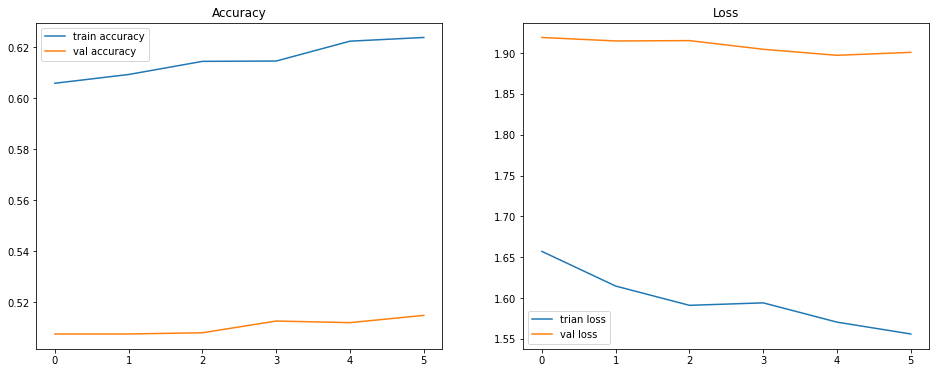

In [25]:
plot_loss_curves(model_0_fine_tune_history)

Khả năng học của mô hình qua 2 giai đoạn qua biểu đồ: 

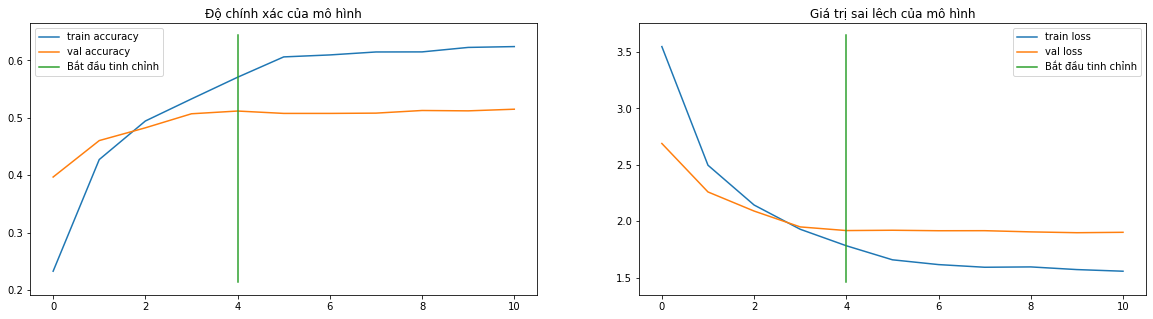

In [26]:
compare_history(model_0_feature_extraction_history, model_0_fine_tune_history)

Qua biểu đồ trên có thể thấy trước giai đoạn tinh chỉnh, mô hình có khả năng học tốt hơn qua từng epoch. Nhưng đến giai đoạn tinh chỉnh, mặc dù khi train, mô hình học rất tốt, nhưng khi kiểm định lại nó không cho thấy sự tiến bộ nào. Điều này cho thấy mô hình đang bị `overfitting`.

Trong trường hợp của chúng ta, mô hình `EfficientNetB0` đã được train trước đó trên **ImageNet** có chứa nhiều hình ảnh thực tế về  food giống như tập dữ liệu của chúng ta. Nếu trích xuất đặc trưng đã làm rất tốt, thì việc tinh chỉnh mô hình, khiến cho các layer có thể train lại trên dữ liệu của chúng ta sẽ khiến các trọng số trước đó không còn được giữ nguyên mà nó thay đổi dựa trên dữ liệu của chúng ta và với lượng dữ liệu quá ít khiến cho việc train các layer này không còn được tốt nữa.



## 5. Lưu và load mô hình

Để không phải mất thời gian train lại mô hình, chúng ta sẽ lưu mô hình trên lại bằng phương thức `save`. Trong bài viết này, chúng ta sẽ lưu trên Google Drive, đầu tiên, bạn cần kết nối đến Driver với lệnh sau : 

### Lưu mô hình

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [27]:
model_0.save("drive/MyDrive/tensorflow/transfer_learning/transfer_learning_scalling_up_model_0")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow/transfer_learning/transfer_learning_scalling_up_model_0/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Sau đó, bạn có thể tải folder vừa lưu về máy, nén thành một file zip và upload lên cloud.

### Load mô hình

Giả sử mô hình đã được lưu, nén lại và tải về máy, bạn sẽ upload nó lên một cloud nào đó của Dropbox hoặc từ Amazone... Sau đó, sử dụng lệnh sau để download xuống 

In [28]:
saved_model_path = "/content/drive/MyDrive/tensorflow/transfer_learning/transfer_learning_scalling_up_model_0"

In [29]:
loaded_model = tf.keras.models.load_model(saved_model_path)

Kiểm tra xem mô hình `loaded_model` có giống như mô hình được save lại hay không (`model_0`) bằng cách đưa dữ liệu `test` để đánh giá `loaded_model`: 

In [30]:
results_loaded_model = loaded_model.evaluate(test_data)
results_loaded_model

790/790 [==============================] - 105s 130ms/step - loss: 1.7402 - accuracy: 0.5516


[1.7402280569076538, 0.5516435503959656]

Xem lại kết quả đánh giá của `model_0` ở trên: 


In [31]:
result_model_0_fine_tune

[1.7402280569076538, 0.5516435503959656]

So sánh : 

In [32]:
result_model_0_fine_tune == results_loaded_model

True


## 6. Đánh giá hiệu suất mô hình

> 🔑 **Lưu ý**: Đánh giá một mô hình trong học máy cũng quan trọng như việc train một mô hình. Khi tiến hành đánh giá, chúng ta không đưa những dữ liệu mà mô hình đã train vào, mà cần đưa những dữ liệu nó chưa từng biết đến để có thể đánh giá được đúng đắn hiệu suất của mô hình. 


### Dự đoán hình ảnh lấy từ dữ liệu test

Để đánh giá mô hình được train của, chúng ta cần đưa ra một số dự đoán với nó và sau đó so sánh những dự đoán đó với tập dữ liệu test.

Bởi vì mô hình chưa bao giờ nhìn thấy tập dữ liệu thử nghiệm, điều này sẽ cung cấp cho chúng ta dấu hiệu về cách mô hình sẽ hoạt động trong thế giới thực trên dữ liệu tương tự như những gì nó đã được train.

Để đưa ra các dự đoán với mô hình được train của, chúng tôi có đưa dữ liệu test vào trong phương thức `predict()`.

Vì dữ liệu của chúng ta có nhiều class, giá trị dự đoán sẽ là một mảng với số phần tử trong mảng tương ứng với số class. Mỗi phần tử thể hiện xác suất xảy ra của class đó, tổng các giá trị của tất cả phần tử là ~1. 

Nói cách khác, mỗi khi mô hình được train khi nhìn thấy một hình ảnh nào đó, nó sẽ so sánh nó với tất cả các mẫu mà nó đã học được trong quá trình train và trả về output (tất cả 101 class) cho thấy khả năng có thể xảy ra hình ảnh đó thuộc class nào.




In [33]:
pred_probs = model_0.predict(test_data,verbose=1)
pred_probs[:5]

790/790 [==============================] - 88s 110ms/step


array([[2.97716856e-01, 2.63235136e-03, 2.80539930e-01, 3.19867795e-05,
        1.44368198e-04, 4.95789063e-05, 7.35873415e-04, 1.02811326e-04,
        1.36219300e-02, 2.73561366e-02, 1.24631319e-04, 1.53683912e-04,
        1.33153182e-02, 6.06349977e-06, 6.15092926e-03, 6.79568911e-04,
        3.28560389e-04, 6.65976619e-03, 1.29633455e-03, 1.09578960e-03,
        7.61159370e-03, 3.68659035e-04, 4.45752579e-04, 1.91580169e-04,
        2.19087698e-03, 1.42249651e-03, 3.37548176e-04, 3.95563547e-04,
        3.14374119e-02, 4.44354228e-04, 5.04295422e-05, 1.16663997e-03,
        5.72345126e-03, 5.11642247e-05, 1.50775118e-02, 4.62340948e-04,
        8.71909957e-04, 1.20047526e-03, 4.77492623e-03, 9.26182605e-04,
        1.52915996e-03, 1.23893027e-03, 4.94559156e-03, 1.51783810e-04,
        6.16476347e-04, 3.99310957e-04, 4.42386419e-03, 1.21619843e-03,
        9.54142615e-06, 1.34407366e-02, 2.03737360e-03, 2.79034459e-04,
        3.99293844e-03, 2.82969996e-02, 9.65911022e-06, 6.385806

In [34]:
pred_probs.shape

(25250, 101)

Có 25250 hình ảnh, và mỗi hình ảnh là một mảng gồm 101 phần tử đại diện cho 101 class, trong đó giá trị của mỗi phần tử là xác suất xảy ra cho class đó. 

VD với hình ảnh đầu tiên :

In [35]:
print(f"Số phần tử được dự đoán cho hình ảnh đầu  tiên : {len(pred_probs[0])}")
print(f"Xác suất xảy ra của 101 class: {pred_probs[0]}")
print(f"Class có giá trị dự đoán cao nhất : {pred_probs[0].max()} tại vị trí {pred_probs[0].argmax()}")

Số phần tử được dự đoán cho hình ảnh đầu  tiên : 101
Xác suất xảy ra của 101 class: [2.97716856e-01 2.63235136e-03 2.80539930e-01 3.19867795e-05
 1.44368198e-04 4.95789063e-05 7.35873415e-04 1.02811326e-04
 1.36219300e-02 2.73561366e-02 1.24631319e-04 1.53683912e-04
 1.33153182e-02 6.06349977e-06 6.15092926e-03 6.79568911e-04
 3.28560389e-04 6.65976619e-03 1.29633455e-03 1.09578960e-03
 7.61159370e-03 3.68659035e-04 4.45752579e-04 1.91580169e-04
 2.19087698e-03 1.42249651e-03 3.37548176e-04 3.95563547e-04
 3.14374119e-02 4.44354228e-04 5.04295422e-05 1.16663997e-03
 5.72345126e-03 5.11642247e-05 1.50775118e-02 4.62340948e-04
 8.71909957e-04 1.20047526e-03 4.77492623e-03 9.26182605e-04
 1.52915996e-03 1.23893027e-03 4.94559156e-03 1.51783810e-04
 6.16476347e-04 3.99310957e-04 4.42386419e-03 1.21619843e-03
 9.54142615e-06 1.34407366e-02 2.03737360e-03 2.79034459e-04
 3.99293844e-03 2.82969996e-02 9.65911022e-06 6.38580695e-02
 6.32484583e-03 1.04442425e-03 6.90810801e-03 1.00492802e-03
 

Tiếp theo, chúng ta sẽ dự đoán label của mỗi class dựa trên vị trí chứa giá trị xác suất cao nhất. 


In [36]:
import numpy as np

In [37]:
y_pred_labels = np.argmax(pred_probs,axis=1)
y_pred_labels[:10]

array([ 0,  0,  7,  0,  0, 78, 29, 46,  2, 41])

Chúng ta sẽ có thể so sánh các label này với các label trên tập dữ liệu `test` để đánh giá thêm mô hình. 

Vì dữ liệu `test` hiện không phải là dữ liệu tuần tự mà nó đã được chia theo cụm với mỗi cụm là 32 hình ảnh. Vì vậy, vì vậy chúng ta không thể so sánh được. Trước hết, chúng ta sẽ phân giải cụm này trở về với hình ảnh tuần tự bằng phương thức `unbatch()`

In [38]:
y_labels = []
for image, label in test_data.unbatch() : 
  y_labels.append(tf.argmax(label).numpy())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Sử dụng các phương pháp đánh giá từ sklearn

Một đánh giá rất đơn giản là sử dụng hàm `accuracy_score()` của Scikit-Learn để so sánh các label thật với các label được dự đoán và trả về xác suất chính xác

In [39]:
from sklearn.metrics import accuracy_score 
sklearn_accuracy = accuracy_score(y_pred_labels,  y_labels)
sklearn_accuracy

0.5516435643564357

So sánh với giá trị đánh giá từ mô hình 

In [40]:
np.isclose(sklearn_accuracy, result_model_0_fine_tune[1]) # Vì trong result_model_0_fine_tune là  list [loss, accuracy]

True

Để đánh giá chi tiết xác suất dự đoán của từng class, chúng ta sẽ tạo `confusion_matrix()` để có thể thấy rõ tỉ lệ dự đoán cụ thể giữa các label 

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
confusion_matrix(y_labels, y_pred_labels)

array([[ 62,   0,   9, ...,   3,   0,  12],
       [  0, 192,   0, ...,   0,   0,   0],
       [ 26,   5, 132, ...,   1,   0,   1],
       ...,
       [  8,   0,   4, ...,  67,   0,   4],
       [  0,   2,   0, ...,   0,  43,   0],
       [  4,   0,   0, ...,   1,   0, 146]])

Nếu sử dụng ma trận như trên sẽ rất khó để nhận biết được ý nghĩa cụ thể của con số đó là gì. Vậy nên, chúng ta sẽ vẽ biểu đồ thể hiện ý nghĩa giữa các con số đó với các label. Trong utility functions đã có sẵn hàm để vẽ confusion matrix này có tên là `plot_confusion_matrix(y_true, y_preds, class_names, norm, savefig)` với  : 
+ y_true : label thực của dữ liệu test.
+ y_preds : label được dự đoán cho dữ liệu test.
+ class_names (mặc định là `None`) : tên label của các class. Nếu không có, nó sẽ tự động chuyển thành số thứ tự. 
+ norm (mặc định `True`) : Liệu có tính tỉ lệ dự đoán hay không. 
+ savefig (mặc định `False`) : có lưu hình ảnh về máy hay không. 

In [43]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(y_true, y_preds, class_names=None, norm=True, savefig=False) : 
  cm = confusion_matrix(y_true, y_preds)
  cm_norm = cm.astype("float") / cm.sum(axis=1)
  
  if class_names : 
    labels = class_names 
  else : 
    labels = range(cm.shape[0])
  
  n_rows=cm.shape[0]
  n_cols=cm.shape[1]
  fig, ax = plt.subplots(figsize=(n_cols, n_rows))
  cax = ax.matshow(cm, cmap=plt.cm.Blues)  
  fig.colorbar(cax)
  ax.set(
      title="Confusion matrix", 
      xlabel="Label dự đoán", 
      ylabel="Label thực",
      xticks=range(cm.shape[0]),
      yticks=range(cm.shape[0]),
      xticklabels=labels,
      yticklabels=labels
  )
  ax.xaxis.set_ticks_position("bottom")
  ax.title.set_size(26)
  plt.xticks(rotation=70,fontsize=14)
  plt.yticks(fontsize=14)

  threshold= (cm.min() + cm.max()) / 2

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) : 
    if norm : 
      plt.text(j,i,
            f"{cm[i,j]} ({cm_norm[i,j]*100:.2f}%)", 
            horizontalalignment="center",
            color="white" if threshold < cm[i,j] else "black"
            )
    else : 
      plt.text(j,i,
            f"{cm[i,j]}", 
            horizontalalignment="center",
            color="white" if threshold < cm[i,j] else "black"
            )
  if savefig : 
    fig.savefig("confusion_matrix.png")

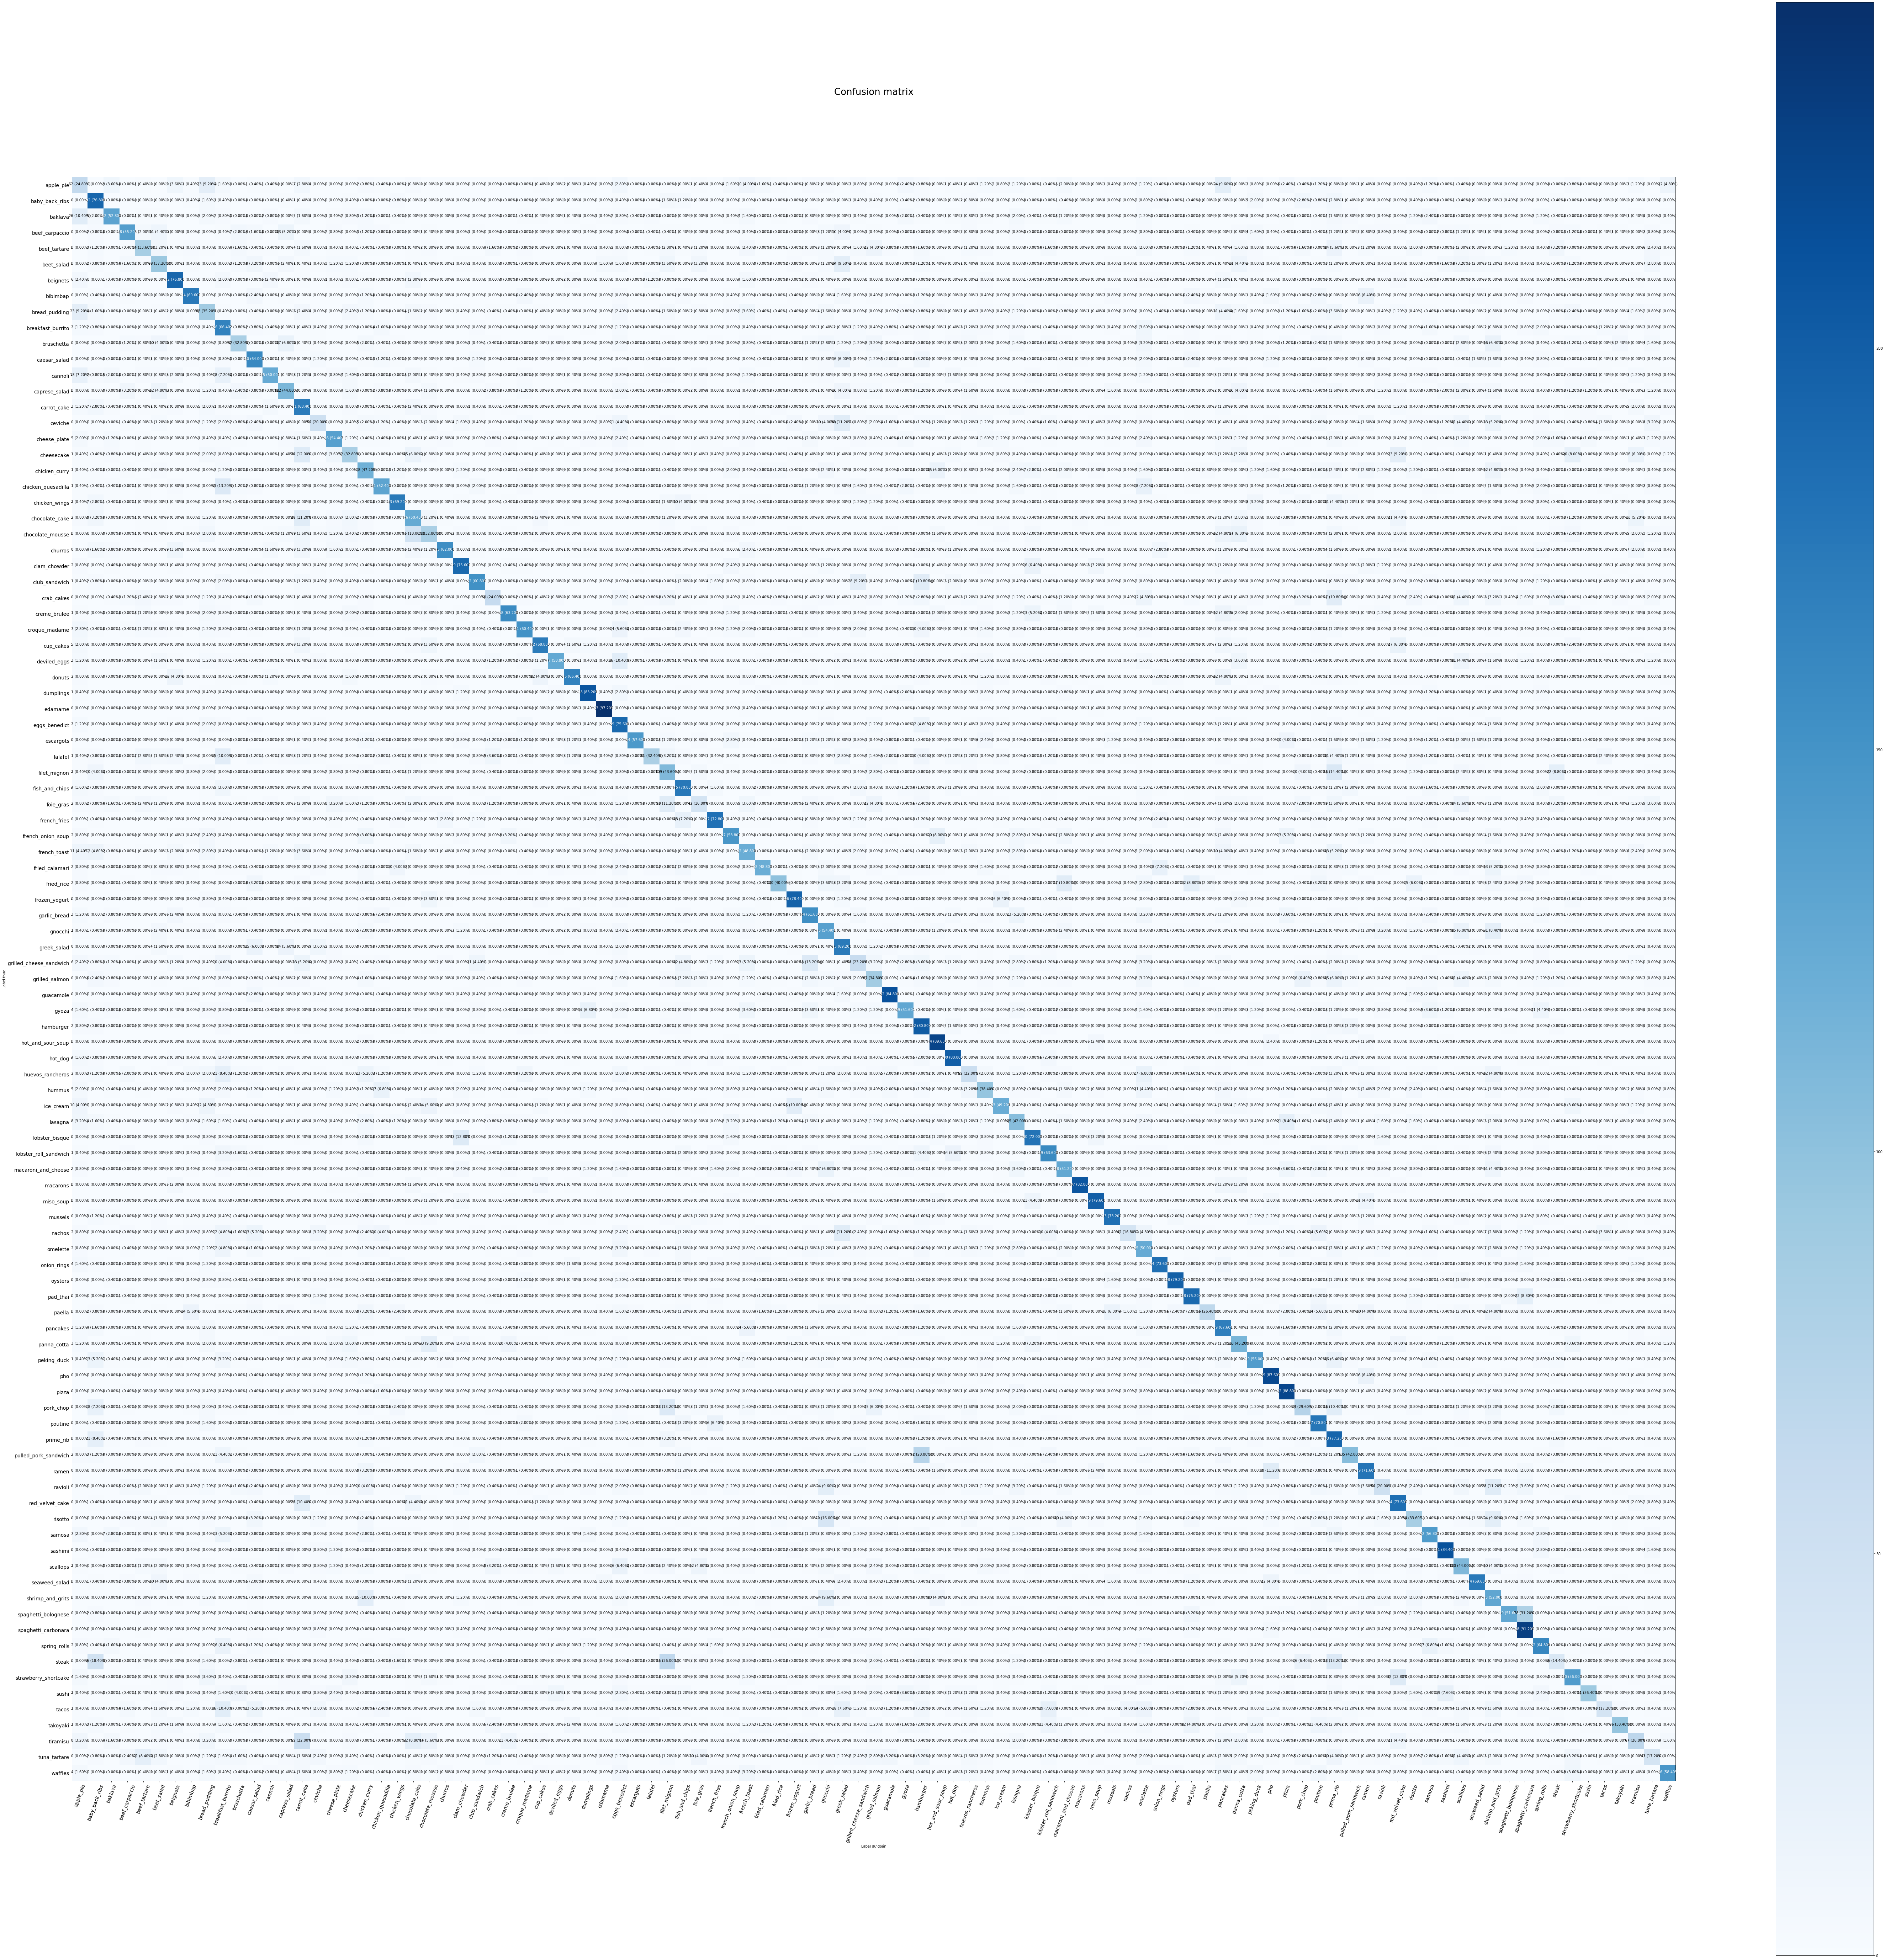

In [44]:
plot_confusion_matrix(y_labels, y_pred_labels, class_names)

### Tìm top các dự đoán sai trong mô hình.

101 tên class với 25250 hình ảnh dự đoán thực sự tạo một ma trận khổng lồ!!!

Thoạt đầu trông có vẻ hơi khó khăn nhưng sau khi phóng to một chút, chúng ta có thể thấy cách nó cho chúng ta cái nhìn sâu sắc về những lớp nào của nó bị "nhầm lẫn".

Chúng ta có thể thấy đường chéo màu xanh là phần dự đoán chính xác mô hình, nếu ô đó càng đậm màu thì đồng nghĩa có nhiều hình ảnh được đoán đúng. Ngược lại, càng lợt thì càng ít hình ảnh đúng. 

Vì chúng ta đang giải quyết vấn đề phân loại, nên có thể đánh giá thêm các dự đoán của mô hình của mình bằng cách sử dụng hàm phân `classification_report()` của Scikit-Learn.

In [45]:
from sklearn.metrics import classification_report 

In [46]:
classification_report_dict = classification_report(y_labels, y_pred_labels, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.22710622710622713,
  'precision': 0.20945945945945946,
  'recall': 0.248,
  'support': 250},
 '1': {'f1-score': 0.5748502994011976,
  'precision': 0.45933014354066987,
  'recall': 0.768,
  'support': 250},
 '10': {'f1-score': 0.4019607843137255,
  'precision': 0.5189873417721519,
  'recall': 0.328,
  'support': 250},
 '100': {'f1-score': 0.6547085201793723,
  'precision': 0.7448979591836735,
  'recall': 0.584,
  'support': 250},
 '11': {'f1-score': 0.5594405594405595,
  'precision': 0.4968944099378882,
  'recall': 0.64,
  'support': 250},
 '12': {'f1-score': 0.6082725060827251,
  'precision': 0.7763975155279503,
  'recall': 0.5,
  'support': 250},
 '13': {'f1-score': 0.4955752212389381,
  'precision': 0.5544554455445545,
  'recall': 0.448,
  'support': 250},
 '14': {'f1-score': 0.4970930232558139,
  'precision': 0.3904109589041096,
  'recall': 0.684,
  'support': 250},
 '15': {'f1-score': 0.2710027100271003,
  'precision': 0.42016806722689076,
  'recall': 0.2,
  's

Trong classification report gồm có : 
+ **Precision** : Tỷ lệ dương đúng (TP) trên tổng số mẫu. Nếu **precision** càng cao thì dẫn đến ít dương sai (FP) (mô hình dự đoán 1 khi đáng ra là 0).
+ **Recall** : Tỷ lệ dương đúng (TP) trên tổng số dương đúng (TP) và âm sai (FN) (mô hình dự đoán 0 khi lẽ ra là 1). **Recall** cao hơn dẫn đến ít âm giả.
+ **F1 score** : Kết hợp giữa **Precision** và **Recall** thành một không gian đo. 1 là tốt nhất, 0 là tệ nhất

![](https://www.researchgate.net/publication/340034692/figure/fig1/AS:870930318385152@1584657377357/Confusion-matrix-and-performance-equations-The-confusion-matrix-included-four.png)

Vì **F1 score** là sự kết hợp của cả 2 phương pháp đánh giá trên, nên chúng ta sẽ lấy F1 để đánh giá cho mô kết quả dự đoán của mô hình thay vì sử dụng cả 3 phương pháp. 

In [47]:
classification_f1_score = {} 

for key, value in classification_report_dict.items() : 
  if key == "accuracy" : 
    break 
  class_name = class_names[int(key)]
  classification_f1_score[class_name] = value["f1-score"]


In [48]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name" : classification_f1_score.keys(), 
                   "f1-score" : classification_f1_score.values()}).sort_values(by="f1-score",ascending=False).reset_index(drop=True)
f1_scores            

class_name  f1-score
0         edamame  0.923954
1        macarons  0.886510
2         oysters  0.830189
3       dumplings  0.809339
4       miso_soup  0.797595
..            ...       ...
96          tacos  0.257485
97      apple_pie  0.227106
98      foie_gras  0.227027
99   tuna_tartare  0.225722
100         steak  0.184615

[101 rows x 2 columns]

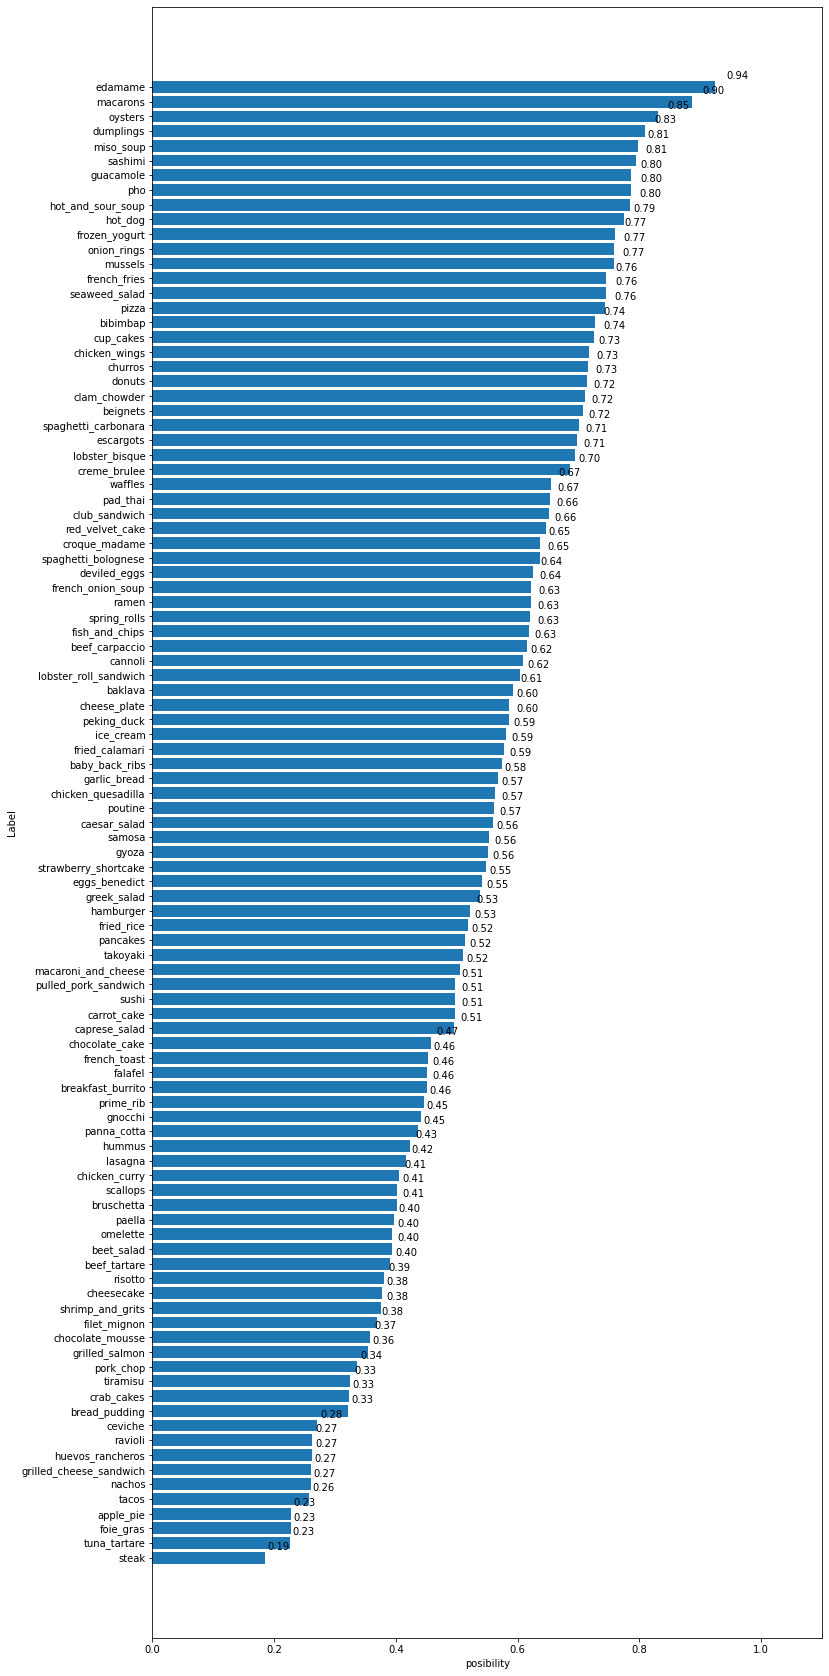

In [49]:
fig, ax = plt.subplots(figsize=(12,30))
scores = ax.barh(f1_scores["class_name"],f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_name"])
ax.set_xlabel("posibility")
ax.set_ylabel("Label")
ax.set_xlim([0,1.1])
ax.invert_yaxis()
for rect in scores : 
  x, y = rect.get_width()*1.02, rect.get_y() 
  plt.text(x,y, f"{x:.2f}",ha="left", va="bottom")

Qua biểu đồ trên, chúng ta phần nào có thể thấy được class nào có tỉ lệ dự đoán của mô hình trên từng class với dữ liệu `test`. 

Bây giờ, chúng ta sẽ lập bảng để xem số liệu dự đoán thực tế  của các hình ảnh trong dữ liệu test : 

Đầu tiên, chúng ta sẽ tạo danh sách đường dẫn đến từng hình ảnh 

In [50]:
filepaths = []

for filepath in test_data.list_files("all_food_classes_10_percent/test/*/*.jpg",shuffle=False) : 
  filepaths.append(filepath.numpy().decode("utf-8"))

filepaths[:5]

['all_food_classes_10_percent/test/apple_pie/1011328.jpg',
 'all_food_classes_10_percent/test/apple_pie/101251.jpg',
 'all_food_classes_10_percent/test/apple_pie/1034399.jpg',
 'all_food_classes_10_percent/test/apple_pie/103801.jpg',
 'all_food_classes_10_percent/test/apple_pie/1038694.jpg']

Để tạo bảng kết quả dự đoán hình ảnh trên dữ liệu test, chúng ta sẽ sử dụng DataFrame trong pandas với các cột sau : 
+ image_path : đường dẫn hình ảnh 
+ y_true : Vị trí thực, 
+ y_pred : Ví trí dự đoán, 
+ pred_conf : xác suất dự đoán cho giá trị cao nhất
+ y_true_clasname : Tên class thực
+ y_pred_classname : Tên class dự đoán
+ result : Kết quả dự đoán

In [51]:
import pandas as pd 

pred_df = pd.DataFrame({
    "image_path" : filepaths, 
    "y_true" : y_labels,
    "y_pred" : y_pred_labels, 
    "pred_conf" : tf.reduce_max(pred_probs,axis=1), 
    "y_true_classname" : [class_names[i] for i in y_labels], 
    "y_pred_classname" : [class_names[i] for i in y_pred_labels], 
    "result" : y_labels == y_pred_labels
})

pred_df

image_path  ...  result
0      all_food_classes_10_percent/test/apple_pie/101...  ...    True
1      all_food_classes_10_percent/test/apple_pie/101...  ...    True
2      all_food_classes_10_percent/test/apple_pie/103...  ...   False
3      all_food_classes_10_percent/test/apple_pie/103...  ...    True
4      all_food_classes_10_percent/test/apple_pie/103...  ...    True
...                                                  ...  ...     ...
25245  all_food_classes_10_percent/test/waffles/94200...  ...    True
25246  all_food_classes_10_percent/test/waffles/95402...  ...    True
25247  all_food_classes_10_percent/test/waffles/96181...  ...   False
25248  all_food_classes_10_percent/test/waffles/97015...  ...   False
25249  all_food_classes_10_percent/test/waffles/97184...  ...   False

[25250 rows x 7 columns]

OK, bảng kết quả dự đoán đã được tạo. Chúng ta có thể đánh giá khả năng dự đoán bằng cách phân tích, thống kê qua bảng trên. 

Top các hình ảnh có xác suất dự đoán cao nhưng lại cho ra kết quả 

In [52]:
top_worst_predict = pred_df[pred_df["result"] == False]
top_worst_predict.sort_values(by="pred_conf",ascending=False)[:20]

image_path  ...  result
23631  all_food_classes_10_percent/test/strawberry_sh...  ...   False
23797  all_food_classes_10_percent/test/sushi/1659357...  ...   False
11097  all_food_classes_10_percent/test/fried_rice/22...  ...   False
18935   all_food_classes_10_percent/test/pho/3741977.jpg  ...   False
21216  all_food_classes_10_percent/test/risotto/49382...  ...   False
17961  all_food_classes_10_percent/test/paella/393031...  ...   False
10854  all_food_classes_10_percent/test/fried_calamar...  ...   False
19484  all_food_classes_10_percent/test/pork_chop/728...  ...   False
11024  all_food_classes_10_percent/test/fried_rice/12...  ...   False
22744  all_food_classes_10_percent/test/spaghetti_bol...  ...   False
15359  all_food_classes_10_percent/test/lobster_roll_...  ...   False
9094   all_food_classes_10_percent/test/falafel/22379...  ...   False
17730  all_food_classes_10_percent/test/pad_thai/7162...  ...   False
18194  all_food_classes_10_percent/test/pancakes/3889...  ...   False
21498  all_food_classes_10_percent/test/samosa/960937...  ...   False
10116  all_food_classes_10_percent/test/french_fries/...  ...   False
22511  all_food_classes_10_percent/test/spaghetti_bol...  ...   False
16437  all_food_classes_10_percent/test/mussels/36730...  ...   False
22684  all_food_classes_10_percent/test/spaghetti_bol...  ...   False
14989  all_food_classes_10_percent/test/lasagna/81697...  ...   False

[20 rows x 7 columns]

Top các label được dự đoán sai nhiều nhất 

In [53]:
worst_labels_predict = pred_df.loc[pred_df["y_true"] != pred_df["y_pred"], "y_true_classname"].value_counts()[:20]

worst_labels_predict = pd.DataFrame(worst_labels_predict)
worst_labels_predict["tỉ lệ sai"] = worst_labels_predict["y_true_classname"] / 750.
worst_labels_predict

y_true_classname  tỉ lệ sai
steak                                 214   0.285333
nachos                                208   0.277333
foie_gras                             208   0.277333
tacos                                 207   0.276000
tuna_tartare                          207   0.276000
ceviche                               200   0.266667
ravioli                               200   0.266667
huevos_rancheros                      195   0.260000
grilled_cheese_sandwich               192   0.256000
crab_cakes                            190   0.253333
apple_pie                             188   0.250667
paella                                184   0.245333
tiramisu                              183   0.244000
pork_chop                             176   0.234667
falafel                               169   0.225333
cheesecake                            168   0.224000
chocolate_mousse                      168   0.224000
bruschetta                            168   0.224000
risotto                               166   0.221333
beef_tartare                          166   0.221333

Top các label được dự đoán đúng nhiều nhất

In [54]:
best_labels_predict = pred_df.loc[pred_df["y_true"] == pred_df["y_pred"], "y_true_classname"].value_counts()
best_labels_predict = pd.DataFrame(best_labels_predict)
best_labels_predict["tỉ lệ"] = best_labels_predict["y_true_classname"] / 750.
best_labels_predict

y_true_classname     tỉ lệ
edamame                           243  0.324000
spaghetti_carbonara               228  0.304000
hot_and_sour_soup                 224  0.298667
pizza                             222  0.296000
pho                               219  0.292000
...                               ...       ...
tuna_tartare                       43  0.057333
tacos                              43  0.057333
foie_gras                          42  0.056000
nachos                             42  0.056000
steak                              36  0.048000

[101 rows x 2 columns]

### Quan sát giá trị dự đoán và giá trị thực 

Để có thể tiến hành dự đoán một hình ảnh nào đó, chúng ta cần biến đổi hình ảnh đó về hình dạng và kiểu giống như những hình đã được train trong mô hình thì mô hình mới có thể hiểu được những gì nó cần làm. 

Cụ thể, chúng ta sẽ tạo một hàm để load và xử lý đồng bộ hình ảnh :

+ Truyền đường dẫn của hình ảnh đến tensorflow `tf.io.read_file()`.
+ Decode hình ảnh thành các giá trị dưới dạng tensor với `tf.image.decode_image()`
+ Resize lại hình ảnh cho cùng kích thước với hình ảnh được train trong mô hình với `tf.image.resize()` 
+ Chuẩn hóa hình ảnh về (0-1) nếu cần thiết. 


In [55]:
def load_and_prep_image(image_path, image_shape=(224,224),scale=True) : 
  image = tf.io.read_file(image_path)
  image = tf.image.decode_image(image,channels=3)
  image = tf.image.resize(image,size=image_shape)
  if scale : 
    return image / 255. 
  return image 

Hàm `load_and_prep_image` có nhiệm vụ đưa hình ảnh về hình dạng `(height, width, color channel)`. Mô hình chỉ có thể hiểu dữ liệu qua hình dạng `(batch_size, height, width, color channel)`. Chính vì vậy, chúng ta sẽ tạo thêm 1 chiều cho hình ảnh để nó có số chiều khớp với dữ liệu mô hình học với việc sử dùng `tf.expand_dims()` để tăng số chiều cho tensor. Nhưng trước hết, chúng ta sẽ tạo hình ảnh ngẫu nhiên để mô hình dự đoán. 

Để thực hiện điều này, chúng ta sẽ tạo hàm lấy hình ảnh ngẫu nhiên với mỗi hình đại diện cho 1 class, số lượng mẫu tùy ý nhưng không vượt quá 7. Sau khi hình ảnh ngẫu nhiên, chúng ta sẽ tiến hành dự đoán nó. 

all_food_classes_10_percent/test/scallops/1844524.jpg
all_food_classes_10_percent/test/beet_salad/1100936.jpg
all_food_classes_10_percent/test/chicken_quesadilla/173397.jpg
all_food_classes_10_percent/test/club_sandwich/3582066.jpg
all_food_classes_10_percent/test/churros/1214695.jpg


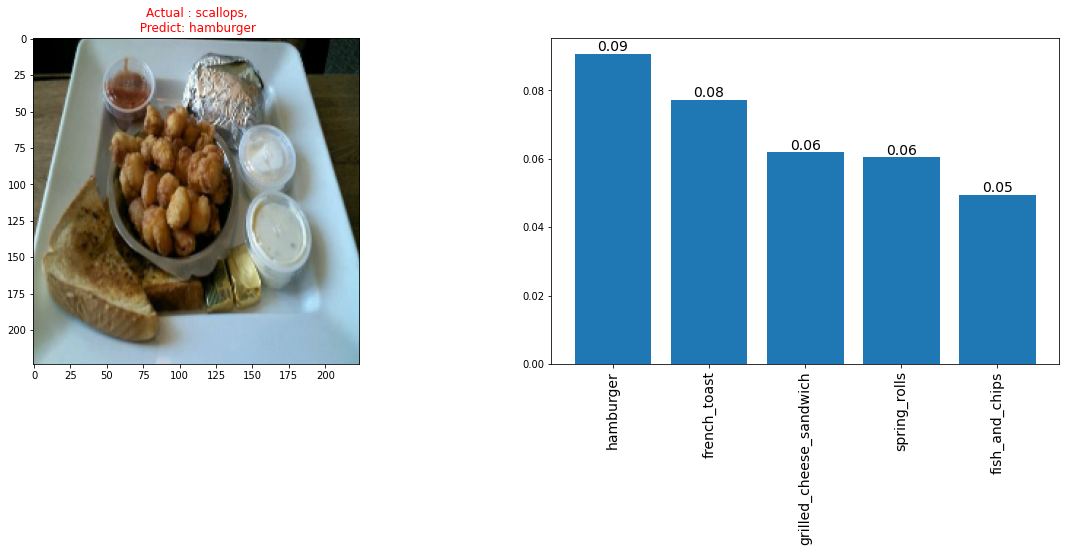

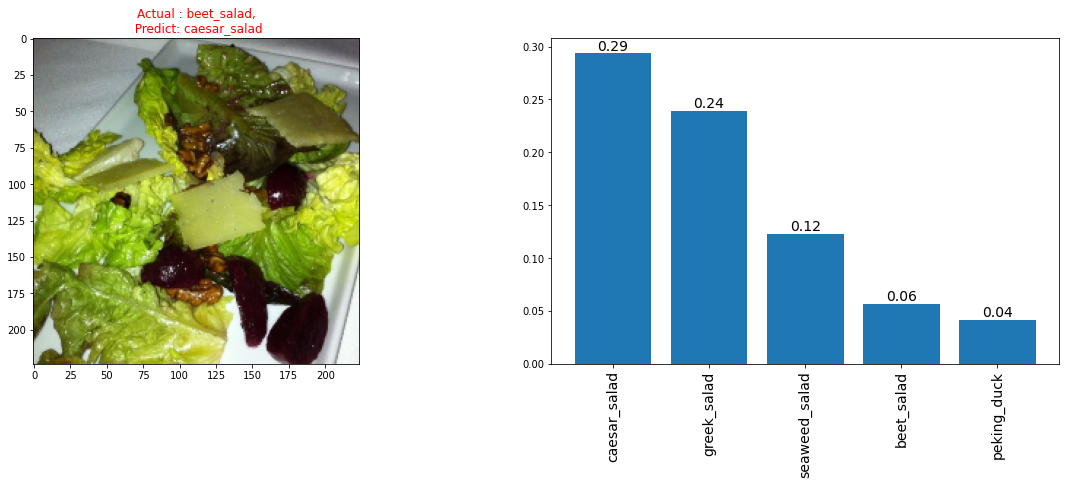

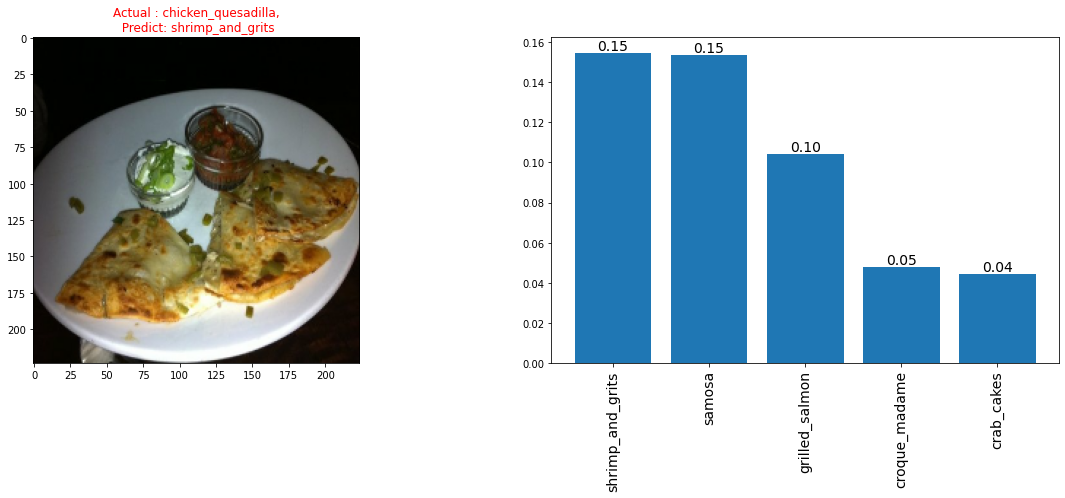

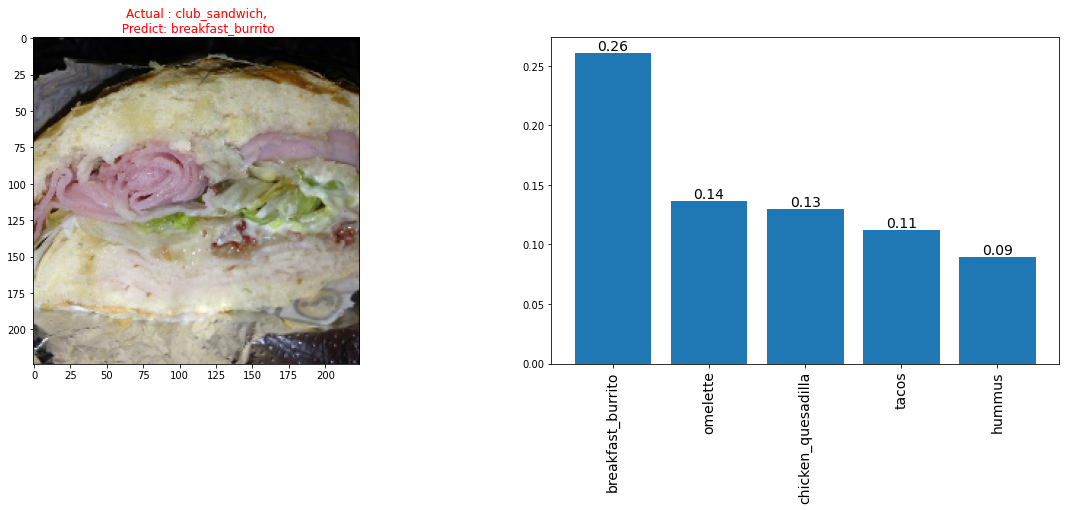

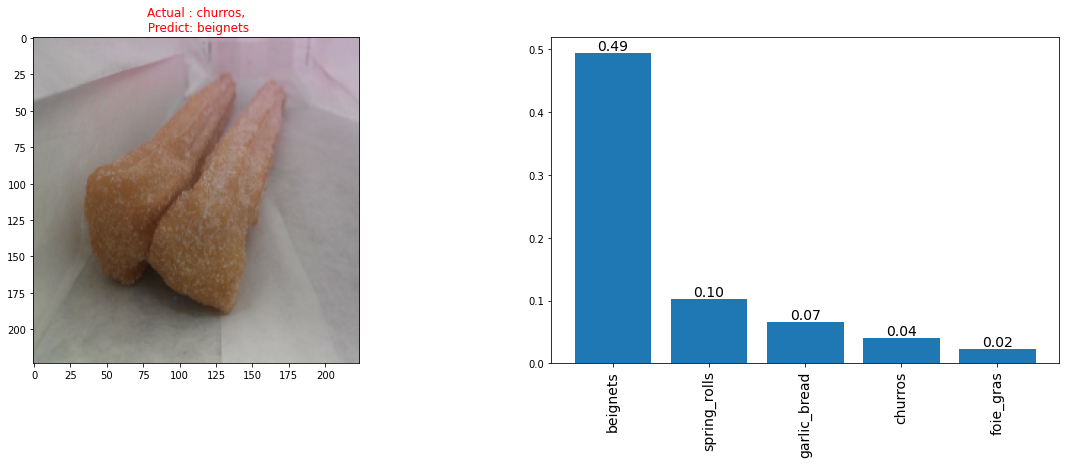

In [56]:
import random
import os 

def predict_random_images(model, target_dir, n_samples=1) : 
  if n_samples > 7 or n_samples < 1 : 
    print("Số lượng mẫu không hợp lệ, chỉ có thể từ 1 đến 7")
    return 
  target_class_names = random.sample(os.listdir(target_dir), k=n_samples)
  # Tạo vòng lặp để tìm hình ảnh ngẫu nhiên với mỗi class name 
  for class_name in target_class_names : 
    target_class_dir = os.path.join(target_dir, class_name) 
    target_image_name = random.choice(os.listdir(target_class_dir))
    target_image_path = os.path.join(target_class_dir, target_image_name)
    print(target_image_path)
    # Load hình ảnh và đồng bộ hình ảnh theo chuẩn mực
    image = load_and_prep_image(target_image_path,scale=False)
    # Dự đoán hình, chúng ta cần thêm 1 chiều(tại vị trí đầu tiên đại diện cho batch size) để mô hình có thể hiểu được dữ liệu dự đoán
    image_pred_probs = model.predict(tf.expand_dims(image, axis=0))
    # Tạo một DataFrame để lưu tên class name tương ứng với xác suất dự đoán, 
    # Sau đó sắp xếp theo thứ tự giảm dần để xem tỉ lệ dự đoán của mô hình trực quan hơn
    preds_df = pd.DataFrame({"class_name" : class_names, "probability" : tf.squeeze(image_pred_probs).numpy()}).sort_values(by="probability", ascending=False).reset_index(drop=True)
    preds_label = preds_df.loc[0,"class_name"]
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))
    ax1.imshow(tf.squeeze(image)/255.)    
    if class_name == preds_label : 
      color = "green"
    else : 
      color = "red"
    ax1.set_title(f"Actual : {class_name},\n Predict: {preds_label}", color=color)
    
    rects = ax2.bar(preds_df["class_name"][:5],preds_df["probability"][:5])
    plt.xticks(rotation=90, fontsize=14)
    for rect in rects : 
      x, w, h = rect.get_x(), rect.get_width(), rect.get_height()
      plt.text(x+w/2,h,f"{h:.2f}", ha="center", va="bottom", fontsize=14)
predict_random_images(model_0, test_dir, n_samples=5)
